In [1]:
import numpy as np         # para fazer contas e mexer com matrizes
import pandas as pd        # para montar DataFrames (tabelas de bancos de dados)

from pathlib import Path   # para trabalhar com diretorios e arquivos
import pickle              # para gravar e ler dados

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#import class_pig  
#import glob
#import seaborn as sns
#
#plt.style.use('ggplot')

#import os
#from scipy.optimize import curve_fit
#"""
#CUIDADO!!
#"""
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# função usada para fitar o modelo PV sigmoide (doente)
#                b                                   b
# V(x) = a + ----------------------   = a + ------------------------
#            1 + exp(-(x/d) + (c/d)          1 + exp(-x/d).exp(c/d)
#
# lim (x-> inf)  V(x) = a + b
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))



# Lendo dados

In [3]:
# verifica quais dados estão disponíveis para análise
for file_name in Path('porquinhos').rglob('*.pickle'):
    print(file_name.name)

porquinho_mra34.pickle
porquinho_mra28.pickle
porquinho_mra31.pickle
porquinho_mra32.pickle
porquinho_mra26.pickle
porquinho_mra29.pickle
porquinho_mra33.pickle


In [4]:
"""
lista de dataframe: Cada elemento da lista corresponde a um dataframe de um porco/manobra/dados PV
"""
dataframes_lst = []

for file_name in Path('porquinhos').rglob('*.pickle'):
    
    print(f"\rLendo {file_name.name}\t\t\t")

    with open(file_name, "rb") as file: # abre o arquivo.pickle

        porquinho = pickle.load(file)
        for manobra in porquinho: #Para cada manobra 

            if manobra == "D": # Posso fazer 3,4,5 passos
                n_steps = 5
            elif manobra == "C": # Posso fazer 3,4 passos
                n_steps = 4
            elif manobra == "B": # Posso fazer 3 passos
                n_steps = 3

            # Formato os dados de entrada
            format_data = []

            for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                      porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                format_data.extend([pi,wi,pe,we])

            format_data = np.array(format_data).reshape(-1,2) # monta matriz de N linhas e 2 colunas
            

            ##########################################################
            caso = []
            caso.append(porquinho.name)
            caso.append(manobra)
            caso.append(format_data)
            caso.append(n_steps)
            casodf = pd.DataFrame(caso, index = ['Animal', 'Manobra', 'Dados', 'n_steps']).T
            dataframes_lst.append(casodf)


Lendo porquinho_mra34.pickle			
Lendo porquinho_mra28.pickle			
Lendo porquinho_mra31.pickle			
Lendo porquinho_mra32.pickle			
Lendo porquinho_mra26.pickle			
Lendo porquinho_mra29.pickle			
Lendo porquinho_mra33.pickle			


In [5]:
dadosdf = pd.concat(dataframes_lst, ignore_index=True)

In [6]:
dadosdf.head(4)

,Animal,Manobra,Dados,n_steps
0,mra34,C,"[[9.928905963897705, -259.58831787109375], [20...",4
1,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5
2,mra34,B,"[[10.135156631469727, -149.72845458984375], [2...",3
3,mra28,C,"[[10.287500381469727, -152.2864532470703], [20...",4


In [7]:
caso_teste = 15
dadosdf.iloc[caso_teste]

Animal                                                 mra29
Manobra                                                    D
Dados      [[10.286250114440918, -210.43722534179688], [2...
n_steps                                                    5
Name: 15, dtype: object

In [8]:
dadosdf.iloc[caso_teste].Dados

array([[  10.28625011, -210.43722534],
       [  20.3008337 ,  -78.49641418],
       [  15.0941205 , -118.89096069],
       [  25.34416771,  -14.55855656],
       [  19.99500084,   33.22951126],
       [  30.33500004,  147.49980164],
       [  25.00092602,  313.02911377],
       [  35.41666794,  434.08279419],
       [  30.0879631 ,  538.45410156],
       [  40.43532372,  647.34619141]])

In [9]:
def Data2PV(data):
    data2 = data[0::2, :]
    pressures = data2[:,0]
    volumes = data2[:,1]
    return pressures,volumes

In [10]:
pv_lst = []
for idx,caso in dadosdf.iterrows():
    pv = []
    #print(f'{caso.Animal} {caso.Manobra}')
    ps,vs = Data2PV(caso.Dados)
    pv.append(idx)
    pv.append(ps)
    pv.append(vs)
    pvdf = pd.DataFrame(pv, index = ['idx','Pressoes', 'Volumes']).T
    pv_lst.append(pvdf)
    #parameters, pcov = curve_fit(func, 
    #                                                     self.interp_pressures,  
    #                                                     self.interp_volumes, 
    #                                                     method=estimator,
    #                                                     bounds=meus_bounds)


In [11]:
pvdf_all = pd.concat(pv_lst, ignore_index=True)
pvdf_all.head(5)

,idx,Pressoes,Volumes
0,0,"[9.928905963897705, 14.968489646911621, 20.058...","[-259.58831787109375, -81.21270751953125, 147...."
1,1,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19..."
2,2,"[10.135156631469727, 15.052343845367432, 20.00...","[-149.72845458984375, 36.645347595214844, 243...."
3,3,"[10.287500381469727, 14.931250095367432, 20.21...","[-152.2864532470703, -45.45492172241211, 234.1..."
4,4,"[10.021874904632568, 14.962499618530273, 20.01...","[-128.87612915039062, -2.0903725624084473, 208..."


In [12]:
dadosdf2 = pd.concat((dadosdf,pvdf_all),axis=1)


In [13]:
dadosdf2

,Animal,Manobra,Dados,n_steps,idx,Pressoes,Volumes
0,mra34,C,"[[9.928905963897705, -259.58831787109375], [20...",4,0,"[9.928905963897705, 14.968489646911621, 20.058...","[-259.58831787109375, -81.21270751953125, 147...."
1,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5,1,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19..."
2,mra34,B,"[[10.135156631469727, -149.72845458984375], [2...",3,2,"[10.135156631469727, 15.052343845367432, 20.00...","[-149.72845458984375, 36.645347595214844, 243...."
3,mra28,C,"[[10.287500381469727, -152.2864532470703], [20...",4,3,"[10.287500381469727, 14.931250095367432, 20.21...","[-152.2864532470703, -45.45492172241211, 234.1..."
4,mra28,B,"[[10.021874904632568, -128.87612915039062], [2...",3,4,"[10.021874904632568, 14.962499618530273, 20.01...","[-128.87612915039062, -2.0903725624084473, 208..."
5,mra28,D,"[[10.240625381469727, -179.3195037841797], [20...",5,5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182...."
6,mra31,D,"[[10.0, -107.7169418334961], [20.2000007629394...",5,6,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19..."
7,mra31,B,"[[10.300000190734863, -25.01786231994629], [20...",3,7,"[10.300000190734863, 15.100000381469727, 19.89...","[-25.01786231994629, 122.25248718261719, 244.6..."
8,mra31,C,"[[9.699999809265137, -228.3211212158203], [20....",4,8,"[9.699999809265137, 15.300000190734863, 20.100...","[-228.3211212158203, -71.18547058105469, 125.5..."
9,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,9,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5..."


In [14]:
caso_teste = 18
metodo = 'dogbox' # lm, dogbox, trf
p = dadosdf2.iloc[caso_teste].Pressoes
v = dadosdf2.iloc[caso_teste].Volumes
parameters, pcov = curve_fit(sigmoid, p, v, method=metodo)
print(parameters)

[-500.91285682 4760.42330962   37.81278584   11.85676109]


In [15]:
meu_p = range(1,100)
meu_v = sigmoid(meu_p,*parameters)


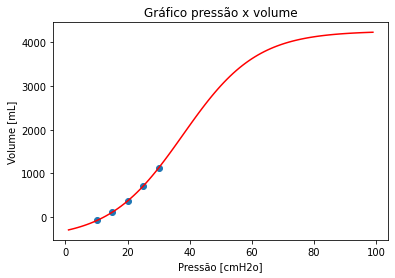

In [16]:
plt.scatter(dadosdf2.iloc[caso_teste].Pressoes,v)
plt.plot(meu_p,meu_v,'r')
plt.title('Gráfico pressão x volume')
plt.xlabel('Pressão [cmH2o]')
plt.ylabel('Volume [mL]')
plt.show()

In [17]:
#meu_p0 = [0, 2000, 20, 20]
#for idx,caso in dadosdf2.iterrows():
#    print(f'Fitando {caso.Animal}_{caso.Manobra}')
#    parameters, pcov = curve_fit(sigmoid, caso.Pressoes, caso.Volumes, method='lm')
#    print(parameters)
#    meu_p = range(1,100)
#    volume_fitado = sigmoid(meu_p,*parameters)
#    plt.plot(caso.Pressoes,caso.Volumes)
#    plt.plot(meu_p,volume_fitado)
#    plt.show()
    #                                                     self.interp_pressures,  
    #                                                     self.interp_volumes, 
    #                                                     method=estimator,
    #                                                     bounds=meus_bounds)